## Context
Olist is the largest department store in Brazilian marketplaces. Olist connects 
small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able 
to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. 
See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer 
receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he 
can give a note for the purchase experience and write down some comments.

## Problem statement

The overall goal is to try and answer one guiding question: how do we increase customer satisfaction (and with it our 
profit margin) while maintaining a healthy volume of orders?


## Dataset desription
This dataset has information about the customer and its location. Use it to identify unique customers in the orders 
dataset and to 
find the orders delivery location.

At our system each order is assigned to a unique customer_id. This means that the same customer will get different ids 
for different orders. The purpose of having a customer_unique_id on the dataset is to allow you to identify customers 
that made repurchases at the store.

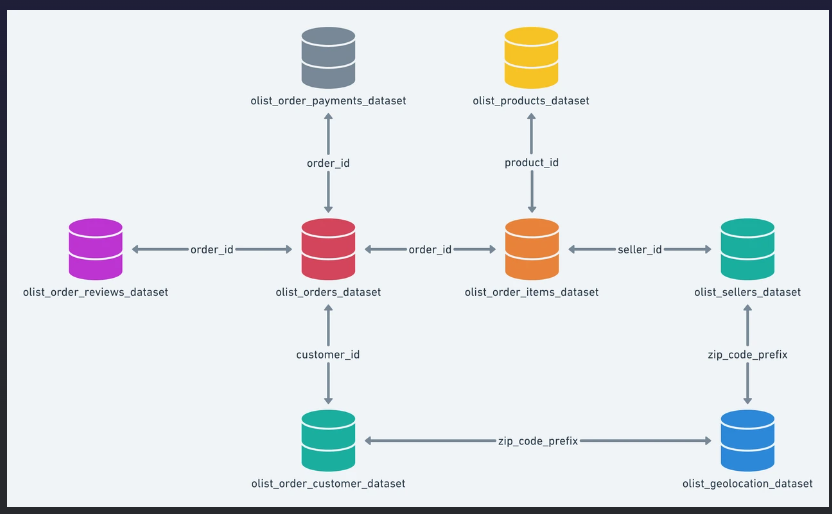


## Note from the data provider
An order might have multiple items.
Each item might be fulfilled by a distinct seller.




#  Libs and constants 

In [2]:
import pandas as pd,os, sys
sys.path.append('./')
sys.path.append('../..')


from src.data.filesystem_reader import FileSystemReader
from src.data.data_server import DataServer



# Loading data 

In [3]:

base_url = './data/'
config = {
    'date_format' : "%Y/%m/%d",
    'base_url': './data/',
    'customers':'olist_customers_dataset.csv',
    'geolocation':'olist_geolocation_dataset.csv',
    'order_items':'olist_order_items_dataset.csv',
    
    'order_payments':'olist_order_payments_dataset.csv',
    'order_reviews':'olist_order_reviews_dataset.csv',
    'orders':'olist_orders_dataset.csv',
    
    'products':'olist_products_dataset.csv',
    'sellers':'olist_sellers_dataset.csv'
}

dataset = DataServer( FileSystemReader(config) )

for key in ['customers','orders','order_reviews']:
    display(key, dataset.fetch(key).sample(2))

order_reviews = dataset.order_reviews
order_reviews.dtypes


'customers'

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
67530,679c8904ab29adbc9094871de22ff44b,09c1ed5035fc97d805f39284b78d445c,11095,santos,SP
14627,59941adf97664d2158b52f86297f0659,6acbe9a0b796a069ec0dc400d74539fe,33400,lagoa santa,MG


'orders'

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
9099,82984749eb983f9f558a003b3fc693f7,17f4da960385fc28aabff33e739e314b,delivered,2017-08-28 22:40:14,2017-08-30 02:11:01,2017-08-31 15:35:07,2017-09-11 18:54:51,2017-09-20
41688,bcafe5369145806f5c012da26c496a39,e283e924531a3ed4cfea8c4bf3b680e3,delivered,2017-09-07 08:14:06,2017-09-07 08:25:17,2017-09-11 15:47:34,2017-09-18 20:27:28,2017-09-27


'order_reviews'

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
87165,742c96e106e62c7d2f808f4c7df4ca1c,aa120c892f79c1304455344f05773ac1,5,NaN,NaN,2018-04-26,2018-04-30 17:51:10
56922,ed806e45411ec419b800eedd8b0fcbe7,bc52ee2d28a015510123067432c70c17,1,NaN,deveria ser avisada no ato da compra que não r...,2017-09-01,2017-09-02 02:00:53


review_id                          object
order_id                           object
review_score                        int64
review_comment_title               object
review_comment_message             object
review_creation_date       datetime64[ns]
review_answer_timestamp    datetime64[ns]
dtype: object

# Understanding the data

### Are there orders without reviews ?    Yes: 768

In [5]:
df =pd.merge( left = dataset.order_reviews[['review_id','order_id']], right = dataset.orders[['order_id']], on='order_id', how='right')
print(pd.isnull(df).sum())
 

review_id    768
order_id       0
dtype: int64


,review_id,order_id
16,NaN,403b97836b0c04a622354cf531062e5f
154,NaN,6942b8da583c2f9957e990d028607019
311,NaN,4906eeadde5f70b308c20c4a8f20be02
382,NaN,b7a4a9ecb1cd3ef6a3e36a48e200e3be
390,NaN,59b32faedc12322c672e95ec3716d614
...,...,...
99242,NaN,0c384d67524b5b92aa2fa6c8baa9a983
99327,NaN,906a6b0a96d89ee226e4977e99b80b9e
99554,NaN,5333db16fe357175d39c82840dd3269d
99684,NaN,2f2df159f26ddb73d55ee72372200d3e



### Relation between orders and reviews:

Each order might have multiple items, and each might have a separate review. Hence, every order id might be 
linked to more than one review id.

Will every review target a single order (a single product inside an order)?  Lets find out  


In [6]:
 
print('reviews that correspond to more than 1 order')
df = order_reviews.groupby(['review_id'])['order_id'].count().sort_values(ascending=False)[0:10]
display ( pd.DataFrame(df).rename({'order_id':'num orders'}, axis=1) )
selected_reviews = list(df.index)

#what? there are reviews that correspond to different orders? 
example_df = order_reviews[order_reviews['review_id']=='ddc52555ca27b0fe67d5255147682d2d']
display('example',example_df)

print(20*'-')
print('Those reviews have the same id but reffer to each of multiple products within a single order, which in turn might be filled by different sellers')
print('this is why there are orders with more than one review')
print('the one-to-one relation is between review and product id ')
df = dataset.order_reviews[ dataset.order_reviews['review_id'].isin(selected_reviews) ][['review_id','order_id','review_score'] ]
pd.merge( left =df, right = dataset.order_items[['order_id','seller_id','product_id']], on='order_id', how='left').sort_values(by='review_id').iloc[0:10]

reviews that correspond to more than 1 order


,num orders
review_id,
ddc52555ca27b0fe67d5255147682d2d,3
2d6ac45f859465b5c185274a1c929637,3
69a1068c3128a14994e3e422e4539e04,3
1fb4ddc969e6bea80e38deec00393a6f,3
832acec9bbf4efe65c3fb6423d8b4ed7,3
39b4603793c1c7f5f36d809b4a218664,3
abbfacb2964f74f6487c9c10ac46daa6,3
44e9f871226d8a130de3fc39dfbdf0c5,3
3415c9f764e478409e8e0660ae816dd2,3


'example'

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
7263,ddc52555ca27b0fe67d5255147682d2d,afed4265a8b956d840bc032e54dfccd1,4,NaN,NaN,2017-08-11,2017-08-12 14:35:03
10112,ddc52555ca27b0fe67d5255147682d2d,3c1098cb17277b62cfc709c7a9b500f5,4,NaN,NaN,2017-08-11,2017-08-12 14:35:03
45434,ddc52555ca27b0fe67d5255147682d2d,d6dde74bdeb424af6b660214881b4845,4,NaN,NaN,2017-08-11,2017-08-12 14:35:03


--------------------
Those reviews have the same id but reffer to each of multiple products within a single order, which in turn might be filled by different sellers
this is why there are orders with more than one review
the one-to-one relation is between review and product id 


,review_id,order_id,review_score,seller_id,product_id
5,0c76e7a547a531e7bf9f0b99cba071c1,3525e0e57f9d276d522d570bd46cb39c,5,d91fb3b7d041e83b64a00a3edfb37e4f,fba6f88e10230dd0ba718aec962064ae
22,0c76e7a547a531e7bf9f0b99cba071c1,16cc0fe71527d13426bdbe29205b2053,5,abc015ebac1d283a323ca9db35ede4b9,5c821d665e58b08092e830f81c12cc37
12,0c76e7a547a531e7bf9f0b99cba071c1,98c977c116f7779360e9fecffd3860b6,5,1127b7f2594683f2510f1c2c834a486b,e4aa3f3e3209009166c6b79afa8204bc
20,1fb4ddc969e6bea80e38deec00393a6f,3c1098cb17277b62cfc709c7a9b500f5,5,cfb1a033743668a192316f3c6d1d2671,d800be06cad2262f48d1c2982fd31189
6,1fb4ddc969e6bea80e38deec00393a6f,d6dde74bdeb424af6b660214881b4845,5,4a3ca9315b744ce9f8e9374361493884,2475f9f6b36857e1a35292cf761ffa48
7,1fb4ddc969e6bea80e38deec00393a6f,d6dde74bdeb424af6b660214881b4845,5,da8622b14eb17ae2831f4ac5b9dab84a,548e5bfe28edceab6b51fa707cc9556f
19,1fb4ddc969e6bea80e38deec00393a6f,afed4265a8b956d840bc032e54dfccd1,5,004c9cd9d87a3c30c522c48c4fc07416,45a19bf9dddef525a5881b62c01f164c
0,2d6ac45f859465b5c185274a1c929637,ef66cc60de5221417b5fb81b1c42de85,1,d91fb3b7d041e83b64a00a3edfb37e4f,ac20a9614b6db9e7289b85c4f4b6216a
25,2d6ac45f859465b5c185274a1c929637,8e17072ec97ce29f0e1f111e598b0c85,1,d91fb3b7d041e83b64a00a3edfb37e4f,ac20a9614b6db9e7289b85c4f4b6216a
9,2d6ac45f859465b5c185274a1c929637,41c284ffd871324eadf06fc989583619,1,d91fb3b7d041e83b64a00a3edfb37e4f,ac20a9614b6db9e7289b85c4f4b6216a


In [7]:
df2 = order_reviews.groupby(['order_id'])['review_id'].count().sort_values(ascending=False)[0:5]
display ( pd.DataFrame(df2).rename({'review_id':'num reviews'}, axis=1) )
selected_orders = list(df2.index)


print('same product, same seller same order and different reviews? How is this possible?')
df2 = dataset.order_reviews[ dataset.order_reviews['order_id'].isin(selected_orders) ][['review_comment_message','review_id','order_id','review_score'] ].sort_values(by='order_id')
df2

merged = pd.merge( left =df2, right = dataset.order_items[['order_id','seller_id','product_id','order_item_id']], on='order_id', how='left').sort_values(by='order_id').iloc[0:60]
merged[ ~merged['review_comment_message'].isnull()]

,num reviews
order_id,
8e17072ec97ce29f0e1f111e598b0c85,3
c88b1d1b157a9999ce368f218a407141,3
03c939fd7fd3b38f8485a0f95798f1f6,3
df56136b8031ecd28e200bb18e6ddb2e,3
29062384ce4975f78aeba6a496510386,2


same product, same seller same order and different reviews? How is this possible?


,review_comment_message,review_id,order_id,review_score,seller_id,product_id,order_item_id
0,Um ponto negativo que achei foi a cobrança de ...,b04ed893318da5b863e878cd3d0511df,03c939fd7fd3b38f8485a0f95798f1f6,3,d91fb3b7d041e83b64a00a3edfb37e4f,ab5da1daa941470d14366f4e76a99dd2,1
2,Seria ótimo se tivesem entregue os 3 (três) pe...,405eb2ea45e1dbe2662541ae5b47e2aa,03c939fd7fd3b38f8485a0f95798f1f6,3,d91fb3b7d041e83b64a00a3edfb37e4f,ab5da1daa941470d14366f4e76a99dd2,1
3,Na foto o produto e um e Na hora que o produto...,f1cba0ac840dac58e4b619bd3424f443,29062384ce4975f78aeba6a496510386,1,11bfa66332777660bd0640ee84d47006,f6129fe69e08f8a94a3ab1e72d9394b6,1
4,Bom amei o produto\r\n,a2a33763a53c33c8f07e58d55855dc77,29062384ce4975f78aeba6a496510386,5,11bfa66332777660bd0640ee84d47006,f6129fe69e08f8a94a3ab1e72d9394b6,1
5,Entregou o produto errado.,67c2557eb0bd72e3ece1e03477c9dff5,8e17072ec97ce29f0e1f111e598b0c85,1,d91fb3b7d041e83b64a00a3edfb37e4f,ac20a9614b6db9e7289b85c4f4b6216a,1
6,Comprei 3 unidades do produto vieram 2 unidade...,2d6ac45f859465b5c185274a1c929637,8e17072ec97ce29f0e1f111e598b0c85,1,d91fb3b7d041e83b64a00a3edfb37e4f,ac20a9614b6db9e7289b85c4f4b6216a,1
7,"Embora tenha entregue dentro do prazo, não env...",6e4c4086d9611ae4cc0cc65a262751fe,8e17072ec97ce29f0e1f111e598b0c85,1,d91fb3b7d041e83b64a00a3edfb37e4f,ac20a9614b6db9e7289b85c4f4b6216a,1



### Relation between product ids and seller ids

##### Is the product id unique for each seller? No: product id is independent of the seller 


A given product id is a generic id or it depends on the seller? 
Namely, assume a product: toothpaste brand x size y.
Assume that more than one seller sells that product. Is the product id unique for each seller? 
If not, then for each product id, there might more than one seller id associated with it.
Lets find out. 



In [8]:

df2 = dataset.order_items.groupby( by =['product_id'], as_index=False )['seller_id'].count()
df2 = pd.DataFrame(df2).rename({'seller_id':'num sellers'}, axis=1).sort_values(by=['num sellers'],ascending=False)[0:10] 
#display( df2 )

print('The product codes are unique and independent of the sellers')
print('Among the 5 products most commonly available from sellers, 3 are gardening tools!')
df2 = pd.merge(left=df2[['product_id']], right = pd.merge( left=df2, right=dataset.products[['product_id','product_category_name']], 
                                          on='product_id', how='left') ,on='product_id',how='right' )
df2

The product codes are unique and independent of the sellers
Among the 5 products most commonly available from sellers, 3 are gardening tools!


,product_id,num sellers,product_category_name
0,aca2eb7d00ea1a7b8ebd4e68314663af,527,moveis_decoracao
1,99a4788cb24856965c36a24e339b6058,488,cama_mesa_banho
2,422879e10f46682990de24d770e7f83d,484,ferramentas_jardim
3,389d119b48cf3043d311335e499d9c6b,392,ferramentas_jardim
4,368c6c730842d78016ad823897a372db,388,ferramentas_jardim
5,53759a2ecddad2bb87a079a1f1519f73,373,ferramentas_jardim
6,d1c427060a0f73f6b889a5c7c61f2ac4,343,informatica_acessorios
7,53b36df67ebb7c41585e8d54d6772e08,323,relogios_presentes
8,154e7e31ebfa092203795c972e5804a6,281,beleza_saude
9,3dd2a17168ec895c781a9191c1e95ad7,274,informatica_acessorios


###  Sellers characteristics.



#### Whats the size of the sellers in terms of orders fullfilled? 

In [9]:
df = dataset.order_items.groupby( by =['seller_id'], as_index=False )[['product_id','price']].\
    agg(
    {
        'product_id':'count',
        'price':'sum'
    }).\
    rename({'product_id':'tot items sold', 'price':'$value sold'},axis=1).\
    sort_values( ['$value sold','tot items sold'], ascending=False)

df=pd.merge( left=df,right=dataset.sellers , on='seller_id',how='left')
display(df.head(15))
display(df.tail(15))

,seller_id,tot items sold,$value sold,seller_zip_code_prefix,seller_city,seller_state
0,4869f7a5dfa277a7dca6462dcf3b52b2,1156,229472.63,14840,guariba,SP
1,53243585a1d6dc2643021fd1853d8905,410,222776.05,42738,lauro de freitas,BA
2,4a3ca9315b744ce9f8e9374361493884,1987,200472.92,14940,ibitinga,SP
3,fa1c13f2614d7b5c4749cbc52fecda94,586,194042.03,13170,sumare,SP
4,7c67e1448b00f6e969d365cea6b010ab,1364,187923.89,8577,itaquaquecetuba,SP
5,7e93a43ef30c4f03f38b393420bc753a,340,176431.87,6429,barueri,SP
6,da8622b14eb17ae2831f4ac5b9dab84a,1551,160236.57,13405,piracicaba,SP
7,7a67c85e85bb2ce8582c35f2203ad736,1171,141745.53,3426,sao paulo,SP
8,1025f0e2d44d7041d6cf58b6550e0bfa,1428,138968.55,3204,sao paulo,SP
9,955fee9216a65b617aa5c0531780ce60,1499,135171.70,4782,sao paulo,SP


,seller_id,tot items sold,$value sold,seller_zip_code_prefix,seller_city,seller_state
3080,c1dde11f12d05c478f5de2d7319ad3b2,1,12.50,1026,sao paulo,SP
3081,3d62f86afa7c73be2628a3be1423f5a0,2,12.00,12327,jacarei,SP
3082,3ac588cd562971392504a9e17130c40b,1,11.90,13480,limeira,SP
3083,cc1f04647be106ba74e62b21f358af25,1,11.90,2739,sao paulo,SP
3084,344223b2a90784f64136a8a5da012e7f,1,10.90,89117,gaspar,SC
3085,95cca791657aabeff15a07eb152d7841,1,9.99,85950,palotina,PR
3086,c18309219e789960add0b2255ca4b091,1,9.90,20521,rio de janeiro,RJ
3087,0f94588695d71662beec8d883ffacf09,1,9.00,88037,florianopolis,SC
3088,4965a7002cca77301c82d3f91b82e1a9,1,8.49,18074,sorocaba,SP
3089,ad14615bdd492b01b0d97922e87cb87f,1,8.25,88704,tubarao,SC


In [10]:
dataset.sellers.groupby( 'seller_city')['seller_id'].nunique().sort_values(ascending=False)

seller_city
sao paulo         694
curitiba          127
rio de janeiro     96
belo horizonte     68
ribeirao preto     52
                 ... 
ivoti               1
itirapina           1
itau de minas       1
itapui              1
xaxim               1
Name: seller_id, Length: 611, dtype: int64

# At this point, we might start asking some questions. For instance:

- Are some sellers systematically getting bad reviews?
- Are some products poorly reviewed in general 
- Are some products negatively reviewed when sold by specific sellers? 
 
